# 01 - TF-IDF on the Governance Set
This notebook runs TF-IDF on the governance data set. It combines analysis and learning, so there are a few things in this notebook that someone experienced in TF-IDF would not need. We leave it in, to show our learning steps.

The learning part of this notebook is based on [TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a) by Mukesh Chaudhary. We replicate their steps and build from there.

Prerequisite: This notebook expects that the "_Explore the Governance Data Set_" notebook has created a clean data set in `CACHE_DIR`.

**braindump**

* TF-idf van alle duurzaamheisdocument: haal je eruit wat de typische DV woorden zijn ten op zichte vban alle woorden. --> traingen met DV subset en dan running met ALL superset.

* Onderscheid maken tussen documenten / clusteren: vectors maken van alle documenten; tfidf van ieder DV document apart t.o.v. alle DV documenten; klassificate *binnen* DV documenten; trainen alle DV docs; test tegen elk DV docui


* anders: pak alleen woorden die echt uniek zijn voor DV set (uit de eerste stap dus); en alleen die neem je mee in de test stap; je reduceret de feature set tot de DV-unieke woorden. Hiermee k-means custering voeden.

* XXX histogram woorden per klasse van document frequency maken voor Corné. Iets van 20 bins. Document frequency uitrekenen. Doel: df_min en df_max bestuderen.

---
## Dependencies and Imports

In [1]:
!pip install pandas scikit-learn wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 9.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import re
import sys
from pathlib import Path
WRITE='w'
READ_BINARY='rb'
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import numpy as np
print(f"numpy=={np.__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")


python==3.11.3
scikit-learn==1.2.2
pandas==2.0.2
numpy==1.24.3
wordcloud==1.9.2
matplotlib==3.7.1


---
## Data Loading
All data was preprocessed by the "_Explore the Governance Data Set_" notebook, so our data loading steps here can be simplified. We don't have to worry about tokenization, stemming and stop words. It is still useful to have convencience functions and constants to make the rest of the code more readable.

In [3]:
CACHE_DIR = '../cache/Governance'

# The files containing the extracted text from the raw documents.
GLOB_ALL_DOCUMENTS = CACHE_DIR + '/GM????????.txt'

GLOB_CA = CACHE_DIR + '/GM????CA??.txt'
GLOB_DV = CACHE_DIR + '/GM????DV??.txt'
GLOB_EX = CACHE_DIR + '/GM????EX??.txt'
GLOB_IK = CACHE_DIR + '/GM????IK??.txt'
GLOB_JS = CACHE_DIR + '/GM????JS??.txt'
GLOB_OB = CACHE_DIR + '/GM????OB??.txt'
GLOB_PB = CACHE_DIR + '/GM????PB??.txt'
GLOB_TV = CACHE_DIR + '/GM????TV??.txt'
GLOB_WS = CACHE_DIR + '/GM????WS??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"all text documents = {GLOB_ALL_DOCUMENTS}")

def load_documents_as_string_array(glob):
    return [file.read_text() for file in expand_glob(glob)]

def document_names(glob):
    return [file.stem for file in expand_glob(glob)]


all text documents = ../cache/Governance/GM????????.txt


---
## Replicate Mukesh' Vectorizers (with Adaptations)

This section replicates [TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a) by Mukesh Chaudhary for the sake of understanding their steps better. We don't use the initialisation parameters from the example. Using a `word` analyser is the default, for example. We pack the result into a Pandas dataframe so it looks nice, adorning the rows and columns with the document names and words used.

We also keep the stop words by _not_ specifying a stop word list. A large part of why we plan on using TF-IDF is so that common words are automatically filtered. Thus, we don't specify `stop_words='english'`.

In [4]:
train_names     = ['Doc1',             'Doc2']
# to test its behaviour, you can try some alternatives
# train_documents = ['The sky is blue. the the the the the the ', 'The sun is bright.']
# train_documents = ['The sky is blue. sky sky sky sky sky sky ', 'The sun is bright.']
train_documents = ['The sky is blue.', 'The sun is bright.']
test_names      = ['Doc3',                         'Doc4']
test_documents  = ['The sun in the sky is bright', 'We can see the shining sun, the bright sun.']


First, the count vectorizer. We train the vectorizer and build up the internal word list. Then we look at the generated word count matrix and take a peek at the internal vocabulary.

In [5]:
def count_vectorize_strings(index, strings, min_df=1, max_df=1.0):
    # run the vectorizer on the data
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    word_matrix = vectorizer.fit_transform(strings)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    per_document    = pd.DataFrame(index=index, columns=words_list, data=word_matrix.toarray())
    sum_over_corpus = pd.DataFrame(per_document.sum(), columns=['sum']).T

    return vectorizer, per_document, sum_over_corpus

count_vectorizer, count_per_document, count_sum_over_corpus = count_vectorize_strings(train_names, train_documents)

# show the word count per document. This is just that: a word count for each
# word in the vocabulary, counted for each document separately.

count_per_document


,blue,bright,is,sky,sun,the
Doc1,1,0,1,1,0,1
Doc2,0,1,1,0,1,1


In [6]:
# show the sum of word counts over the corpus

count_sum_over_corpus


,blue,bright,is,sky,sun,the
sum,1,1,2,1,1,2


In [7]:
# take a peek at the internal word list of the vectorizer. The numbers are
# internal indices into its private data structure. Not very useful for our
# code, but still good to get some idea of how the vectorizer works internally.

pd.DataFrame().from_dict(count_vectorizer.vocabulary_, orient='index', columns=['vocabulary index']).sort_values('vocabulary index').T


,blue,bright,is,sky,sun,the
vocabulary index,0,1,2,3,4,5


Next, we explore the TF-IDF vectorizer, which internally consists of a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), followed by a [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).


In [8]:
def tfidf_vectorize_strings(index, strings, min_df=1, max_df=1.0, max_features=None):
    # run the vectorizer on the data
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features)
    word_matrix = vectorizer.fit_transform(strings)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return vectorizer, matrix, idf

tfidf_vectorizer, tfidf_matrix, tfidf_idf = tfidf_vectorize_strings(train_names, train_documents)
tfidf_matrix

# XXX ask Marieke to explain why the numbers are not 0 for the stop words.


,blue,bright,is,sky,sun,the
Doc1,0.576152,0.000000,0.409937,0.576152,0.000000,0.409937
Doc2,0.000000,0.576152,0.409937,0.000000,0.576152,0.409937


In [9]:
tfidf_idf

,blue,bright,is,sky,sun,the
0,1.405465,1.405465,1.0,1.405465,1.405465,1.0


### Stop Word Elimination with `max_df`
We can control stop word elimination with the `max_df` parameter. Setting that value to `1.0` effectively disables stop word elimination. Any other value between 0.0 and 1.0 represents more or less strict stop word removal. The default value for `max_df` is 1.0, which essentially means "keep all words". If we try lowering `max_df`, the vectorizer starts eliminating words that do not have much information in them. We might try a value of 0.5, for example, and look at the resulting matrix and the list of words that were eliminated this way.

In [10]:
tfidf_vectorizer, tfidf_matrix, tfidf_idf = tfidf_vectorize_strings(train_names, train_documents, max_df=0.5)
tfidf_matrix


,blue,bright,sky,sun
Doc1,0.707107,0.000000,0.707107,0.000000
Doc2,0.000000,0.707107,0.000000,0.707107


In [11]:
# Let's have a quick peek at the stop word list that the vectorizer built up.

tfidf_vectorizer.stop_words_


{'is', 'the'}

Then the inference step, this does not modify the internal state of the vectorizer anymore. We reuse the structure of the data frames that we generated during training to make the new data frame more readable.

In [12]:
# Here we use the count vectorizer again, which does not have a stop word list
# and thus will show values for "the" and "is". The TF-IDF vectorizer comes
# after.

count_vector = count_vectorizer.transform(test_documents)
pd.DataFrame(index=test_names, columns=count_per_document.columns,
             data=count_vector.todense())

,blue,bright,is,sky,sun,the
Doc3,0,1,1,1,1,2
Doc4,0,1,0,0,2,2


In [13]:
# and using the last TF-IDF vectorizer, which does have stop word elimination.

tfidf_data = tfidf_vectorizer.transform(test_documents).todense()
pd.DataFrame(index=test_names, columns=tfidf_matrix.columns,
             data=tfidf_data)


,blue,bright,sky,sun
Doc3,0.0,0.577350,0.57735,0.577350
Doc4,0.0,0.447214,0.00000,0.894427


### Stop Word Elimination using `max_features`
An alternative to using `max_df` is to use `max_features` to control stop word elimination. `max_features` sets an upper limit on the number of words in the vocabulary, ordered by term frequency.

In [14]:
tfidf_vectorizer, tfidf_matrix, tfidf_idf = tfidf_vectorize_strings(train_names, train_documents, max_features=2)
tfidf_matrix


,is,the
Doc1,0.707107,0.707107
Doc2,0.707107,0.707107


In [15]:
# Let's have a quick peek at the stop word list that the vectorizer built up.

tfidf_vectorizer.stop_words_


{'blue', 'bright', 'sky', 'sun'}

... oh. So this gives us the _reverse_ of what we need. This shows that using term frequency for this purpose is not really useful.

### Stop Word Elimination with `min_df`
The most effective way of stop word elimination seems to be to set a minimum number of documents that words have to be found in. Words that do not meet this bar are eliminated from the set considered for processing.

---
## Apply Vectorizers to Governance Data Set
With the howto replicated, we can now apply the same to our own data sets. We reimplement the methods here to rely on file globs rather than using string arrays. We could reduce the code duplication somewhat, but that's not really high priority at this stage.

As our documents are quite large, we set `sublinear_tf` to apply a $log()$ to the TF. This reduces the significance of document size on the output.

In [16]:
def tfidf_vectorize(glob, min_df=1, max_df=1.0, sublinear_tf=False):
    # run the vectorizer on the data
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)
    word_matrix = vectorizer.fit_transform(load_documents_as_string_array(glob))
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=document_names(glob), columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return vectorizer, matrix, idf


In [17]:
all_docs_vectorizer, all_docs_matrix, all_docs_idf = tfidf_vectorize(GLOB_ALL_DOCUMENTS, min_df=15, max_df=0.9, sublinear_tf=True)
all_docs_matrix

,aaa,aachen,aal,aalburg,aalen,aalsmeer,aalt,aalten,aanaantonen,aanbe,...,zwerfafvalen,zwerfafvalvergoeding,zwerfaval,zwerfdieren,zwerfjongeren,zwerfvuil,zwerfvuilactie,zwijndrecht,zwolle,zzp
GM0003DV02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0003EX06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0003OB01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017320
GM0003OB02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0005CA01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1987DV01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.055334,0.0,0.0,0.000000
GM1987IK01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM1987JS01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM1987PB01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [18]:
#all_docs_vectorizer.stop_words_
len(all_docs_vectorizer.stop_words_)

317912

In [19]:
dv_docs_vectorizer, dv_docs_matrix, dv_docs_idf = tfidf_vectorize(GLOB_DV, min_df=15, max_df=1.0, sublinear_tf=True)
dv_docs_matrix

,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuiniger,zuiveren,zuivering,zullen,zwaar,zwart,zwembad,zwerfafval,zwerfvuil,één
GM0003DV02,0.000000,0.011333,0.000000,0.000000,0.000000,0.035836,0.027979,0.0,0.0,0.011542,...,0.0,0.000000,0.000000,0.035290,0.000000,0.000000,0.000000,0.000000,0.00000,0.023429
GM0005DV01,0.000000,0.013583,0.000000,0.000000,0.000000,0.000000,0.012011,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.030524,0.000000,0.000000,0.000000,0.086667,0.00000,0.028079
GM0007DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016585,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.035369,0.014752,0.000000,0.000000,0.035503,0.04699,0.028054
GM0009DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016825,0.0,0.0,0.032807,...,0.0,0.000000,0.000000,0.040522,0.000000,0.000000,0.030985,0.000000,0.00000,0.030480
GM0034DV01,0.000000,0.014506,0.027009,0.000000,0.000000,0.000000,0.012828,0.0,0.0,0.000000,...,0.0,0.000000,0.030366,0.040527,0.032710,0.034474,0.000000,0.000000,0.00000,0.034717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.000000,0.021797,0.017006,0.025570,0.044121,0.000000,0.013676,0.0,0.0,0.000000,...,0.0,0.031988,0.000000,0.022579,0.020596,0.000000,0.000000,0.000000,0.00000,0.018064
GM1955DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021559,0.0,0.0,0.014664,...,0.0,0.000000,0.000000,0.033791,0.045761,0.000000,0.000000,0.000000,0.00000,0.020286
GM1955DV02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.024042,...,0.0,0.000000,0.000000,0.025776,0.000000,0.056102,0.000000,0.000000,0.00000,0.033259
GM1955DV03,0.000000,0.000000,0.000000,0.000000,0.000000,0.079143,0.012764,0.0,0.0,0.014700,...,0.0,0.000000,0.000000,0.024289,0.000000,0.000000,0.000000,0.000000,0.00000,0.009690


In [20]:
#dv_docs_vectorizer.stop_words_#
len(dv_docs_vectorizer.stop_words_)


62602

### `min_df` and `max_df` Tuning
In order to determine useful values for `min_df` and `max_df`. For that we need a histogram of the terms in the document. To be precise, we need to know for each term, in how many documents that term is used.

We start with the count vectorizer and in each column count how many rows are non-zero.



XXX
* histogram df met aantal woorden binnen de DV set, zodat je kunt zien wat df_min en df_max doen.

count vectorizer; max op 1; sum of 1's per column/term

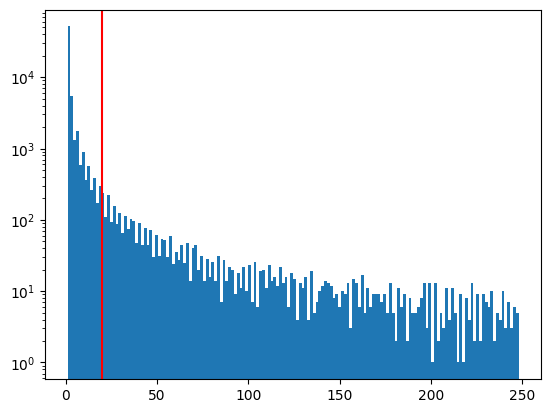

In [21]:
_, count_per_dv_document, _ = count_vectorize_strings(document_names(GLOB_DV), load_documents_as_string_array(GLOB_DV))

plt.yscale('log')
plt.axvline(x=20, color='red')
plt.hist(count_per_dv_document.astype(bool).sum(axis=ROW), bins=160);


In [22]:
count_per_dv_document

,aaa,aab,aachen,aachener,aadefg,aadijk,aagegee,aagehaakt,aageoe,aaissoy,...,zwols,zwoud,zzh,zzp,zzplen,zzprs,zzps,zzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,één
GM0003DV02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
GM0005DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
GM0007DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
GM0009DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
GM0034DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
GM1955DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
GM1955DV02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
GM1955DV03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
total_DV = dv_docs_matrix.mean().dropna().sort_values()
total_DV.nlargest(60)


gemeente            0.048043
duurzaam            0.045570
energie             0.039054
duurzaamheid        0.035374
maken               0.035366
bedrijf             0.034351
project             0.034145
zullen              0.033430
gaan                0.033311
jaar                0.033268
gemeentelijk        0.033087
komen               0.032217
goed                0.032080
mogelijk            0.031741
ander               0.031729
moeten              0.031482
ontwikkeling        0.031023
geven               0.030771
nieuw               0.030594
willen              0.030267
organisatie         0.030176
binnen              0.029374
lokaal              0.029162
gebied              0.028846
groot               0.028375
belangrijk          0.028249
waar                0.028147
per                 0.028123
woning              0.028111
stimuleren          0.028091
bestaan             0.027993
maatregel           0.027923
gebouw              0.027742
uitvoeren           0.027408
ver           

---
## Word Cloud of Unique Words in DV vs All
Here we subtract the two word matrixes "all" and "dv" to determine what words are identifying for DV documents.

In [24]:
unique_for_DV = (dv_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
unique_for_DV.nlargest(20)


duurzaam            0.024799
energie             0.023987
duurzaamheid        0.019040
energiebesparing    0.017746
project             0.015776
bedrijf             0.015132
gebouw              0.013866
elektrisch          0.013641
uitstoot            0.013541
ambitie             0.013336
maatregel           0.013126
energieverbruik     0.012745
mobiliteit          0.012688
klimaat             0.012317
thema               0.012209
energieneutraal     0.012207
warmte              0.012181
klimaatbeleid       0.012045
biomassa            0.011974
verduurzamen        0.011846
dtype: float64

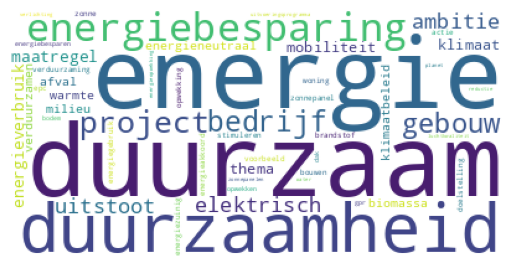

In [25]:
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_DV)
plt.axis('off')
plt.imshow(cloud);


In [26]:
unique_on_idf = (dv_docs_idf.T - all_docs_idf.T).dropna()
unique_on_idf[0].nlargest(20)

raming                 1.664653
jaarrekening           1.661712
heffing                1.620425
voorzieningenniveau    1.601088
kinderopvang           1.591590
gezondheidzorg         1.575842
verloop                1.556890
transparantie          1.546633
toevoeging             1.496812
bijstand               1.453794
meerjarenbegroting     1.447363
afwijking              1.441481
politie                1.398976
woz                    1.378641
informeel              1.351938
control                1.348976
kavel                  1.342892
kwaliteitsniveau       1.339655
arbeidmarkt            1.334956
voorafgaan             1.332743
Name: 0, dtype: float64

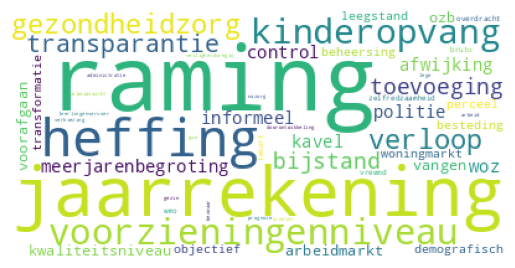

In [27]:
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_on_idf[0])
plt.axis('off')
plt.imshow(cloud);


In [28]:
dv_docs_idf.T[0].nlargest(10)

aangepa         3.744864
aanname         3.744864
aanwenen        3.744864
afgeleide       3.744864
afgeven         3.744864
afspelen        3.744864
afvalstroom     3.744864
afwenteling     3.744864
algeheel        3.744864
algemeenheid    3.744864
Name: 0, dtype: float64

In [29]:
* histogram df met aantal woorden binnen de DV set, zodat je kunt zien wat df_min en df_max doen.

* scree plot om aantal topics te bepalen
    - https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis
    
* commonality value @Mariek

* daar een beperkte set topics maken en dan per combinatie een scatterplot van de woord gewichten.


SyntaxError: invalid syntax (694645252.py, line 1)

In [ ]:
dv_docs_vectorizer, dv_docs_matrix_95, dv_docs_idf = tfidf_vectorize(GLOB_DV, min_df=15, max_df=0.95, sublinear_tf=True)
dv_docs_matrix_95.dropna().sort_values().nlargest(50)


In [ ]:
dv_docs_vectorizer, dv_docs_matrix_90 dv_docs_idf = tfidf_vectorize(GLOB_DV, min_df=15, max_df=0.90, sublinear_tf=True)
dv_docs_matrix_90.dropna().sort_values().nlargest(50)


In [ ]:
dv_docs_vectorizer, dv_docs_matrix_85, dv_docs_idf = tfidf_vectorize(GLOB_DV, min_df=15, max_df=0.85, sublinear_tf=True)
dv_docs_matrix_85.dropna().sort_values().nlargest(50)
